# Import thư viện


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import random
from deap import base, creator, tools, algorithms
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Đọc dữ liệu

In [4]:
# Đọc dữ liệu vào DataFrame
df = pd.read_csv(r'E:\CoChau\Fair_2024_LSTM_GA-LSTM_BiLSTM_GA-BiLSTM\Code\data\data_t_2\TongMua_KaNak_AnKhe_t-2.csv')

# Xử lý dữ liệu bị thiếu
df = df.dropna()

In [5]:
df.head(5)

,thoi_gian_KaNak,thoi_gian_AnKhe,Tổng lưu lượng xả (m³/s)[Thực tế],Lưu lượng đến hồ (m³/s),Sum_Mua
0,2019-10-02 00:00:00,2019-10-02 02:00:00,0.0,10.67,0.0
1,2019-10-02 01:00:00,2019-10-02 03:00:00,0.0,4.00,0.0
2,2019-10-02 02:00:00,2019-10-02 04:00:00,0.0,2.50,0.0
3,2019-10-02 03:00:00,2019-10-02 05:00:00,0.0,2.27,0.0
4,2019-10-02 04:00:00,2019-10-02 06:00:00,0.0,2.15,0.0


# Tạo dữ liệu huấn luyện

In [6]:
# Tạo dữ liệu huấn luyện
def create_dataset(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i+n_steps])
        ys.append(y[i+n_steps])

    return np.array(Xs), np.array(ys)

# Chuẩn hóa và chia bộ dữ liệu cho mô hình LSTM

In [7]:
def split_data(df, window_size):
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    X = df[['Tổng lưu lượng xả (m³/s)[Thực tế]', 'Lưu lượng đến hồ (m³/s)', 'Sum_Mua']]
    y = df[['Lưu lượng đến hồ (m³/s)']]
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)

    # Tạo nhãn cho dữ liệu
    window_size = 24 * window_size
    X_data, y_data = create_dataset(X, y, window_size)

    # Chia dữ liệu thành tập huấn luyện, kiểm tra và test
    train_length = int(len(X) * 0.7)
    val_length = int((len(X) - train_length) / 2)

    X_train, y_train = X_data[:train_length], y_data[:train_length]
    X_val, y_val = X_data[train_length:train_length+val_length], y_data[train_length:train_length+val_length]
    X_test, y_test = X_data[-val_length:], y_data[-val_length:]

    # Reshape dữ liệu đầu vào
    X_train = X_train.reshape(X_train.shape[0], window_size, X_train.shape[2])
    X_val = X_val.reshape(X_val.shape[0], window_size, X_val.shape[2])
    X_test = X_test.reshape(X_test.shape[0], window_size, X_test.shape[2])

    return X_train, y_train, X_val, y_val, X_test, y_test

# Xây dựng mô hình GA - LSTM

### Áp dụng GA để chọn ra cá thể tốt nhất

In [8]:
def model_lstm(input_shape, units):
    # Xây dựng mô hình LSTM với số units và window size được đưa vào
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, activation='tanh', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    return model

In [ ]:
def objective_function(units, window_size, model_checkpoint=None, early_stopping=None, epochs=1):
    # Tách dữ liệu
    X_train, y_train, X_val, y_val, _, _ = split_data(df, window_size)

    # Mô hình LSTM
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = model_lstm(input_shape, units)

    # Compile mô hình
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

    # Thiết lập callbacks
    callbacks = []
    if early_stopping:
        callbacks.append(early_stopping)
    if model_checkpoint:
        callbacks.append(model_checkpoint)

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, 
                        epochs=epochs,
                        batch_size=24,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=callbacks)

    # Hàm mục tiêu
    val_loss = np.min(history.history['val_loss'])

    return val_loss, model, history

# Hàm đánh giá cá thể trong quần thể
def evaluate(individual):
    units = individual[0]
    window_size = individual[1]

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    val_loss, _, _ = objective_function(units, window_size, model_checkpoint=None, early_stopping=early_stopping, epochs=300)

    return val_loss,

# Định nghĩa hàm tạo cá thể trong quần thể
def create_population(n, units_func, window_size_func):
    return [creator.Individual([units_func(), window_size_func()]) for _ in range(n)]

# Khởi tạo hàm mục tiêu
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Khởi tạo toolbox
toolbox = base.Toolbox()
toolbox.register("units", random.choice, [16, 32, 64, 128])  # Giới hạn cho số units
toolbox.register("window_size", random.randint, 1, 7)  # Giới hạn cho window size
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.units, toolbox.window_size), n=1)
toolbox.register("population", create_population, units_func=toolbox.units, window_size_func=toolbox.window_size)

# Đăng ký các toán tử lai ghép và đột biến
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[16, 1], up=[128, 7], indpb=0.15)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)


# Số lượng quần thể ban đầu
num_populations = 4
# Số lượng cá thể trong quần thể ban đầu
individuals = 10

# Tạo quần thể ban đầu
populations = []
for i in range(num_populations):
    population = create_population(individuals, units_func=toolbox.units, window_size_func=toolbox.window_size)
    populations.append(population)
    print(f"Quần thể {i + 1} ban đầu:")
    for j, ind in enumerate(population):
        print(f"Cá thể thứ {j}: {ind}")
    print()

# Đánh giá fitness và chọn lọc cá thể tốt nhất cho mỗi quần thể ban đầu
best_individuals = []
for population in populations:
    fits = toolbox.map(toolbox.evaluate, population)
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit
    best_ind = min(population, key=lambda ind: ind.fitness.values)
    best_individuals.append(best_ind)
    print(f"Cá thể tốt nhất trong quần thể thứ {populations.index(population) + 1}: {best_ind} ban đầu")
print()

print("Bắt đầu quá trình lai ghép và đột biến...")
print()

# Quá trình lai ghép và đột biến
num_generations = 2
for gen in range(num_generations):
    # Tạo quần thể con bằng cách lai ghép và đột biến từ các cá thể tốt nhất
    offspring = algorithms.varAnd(best_individuals, toolbox, cxpb=0.7, mutpb=0.15)
    # offspring = algorithms.varAnd(best_individuals, toolbox, mutpb=0.15)
    print(f"Quần thể con F{gen + 1} đã được tiến hóa:")
    for i, ind in enumerate(offspring):
        print(f"Cá thể thứ {i}: {ind}")

    # Đánh giá fitness của quần thể con
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    best_ind = min(offspring, key=lambda ind: ind.fitness.values)
    best_individuals.append(best_ind)
    print(f"Cá thể tốt nhất trong quần thể con F{gen + 1}: {best_ind}")

    # Chọn lọc cá thể để tạo quần thể mới cho thế hệ tiếp theo
    best_individuals = toolbox.select(offspring, k=len(best_individuals))
    print()

# In ra cá thể tốt nhất cuối cùng
best_ind = min(best_individuals, key=lambda ind: ind.fitness.values)
print("Cá thể tốt nhất cuối cùng:")
print(best_ind)

### Training mô hình với cá thể tốt nhất

In [11]:
# Lấy tham số từ cá thể tốt nhất
units = best_ind[0]
window_size = best_ind[1]

# Chia dữ liệu
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, window_size=window_size)
print("Kích thước tập huấn luyện:", len(X_train))
print("Kích thước tập validation:", len(X_val))
print("Kích thước tập kiểm tra:", len(X_test))

Kích thước tập huấn luyện: 20992
Kích thước tập validation: 4498
Kích thước tập kiểm tra: 4498


In [ ]:
# Lưu lại model tốt nhất
best_model = './best_model/Model_GA-LSTM.hdf5'
model_checkpoint = ModelCheckpoint(best_model, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Mô hình LSTM với tham số tốt nhất
_, model, history = objective_function(units, window_size, 
                                       model_checkpoint=model_checkpoint, early_stopping=None, 
                                       epochs=300)

Epoch 1/5
867/875 [============================>.] - ETA: 0s - loss: 6.3995e-04
Epoch 1: val_loss improved from inf to 0.00023, saving model to ./best_model\Model_GA-LSTM.hdf5
875/875 [==============================] - 6s 5ms/step - loss: 6.3668e-04 - val_loss: 2.2784e-04
Epoch 2/5
 37/875 [>.............................] - ETA: 3s - loss: 5.7673e-04

c:\Users\ductr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


870/875 [============================>.] - ETA: 0s - loss: 3.7345e-04
Epoch 2: val_loss improved from 0.00023 to 0.00017, saving model to ./best_model\Model_GA-LSTM.hdf5
875/875 [==============================] - 4s 5ms/step - loss: 3.7597e-04 - val_loss: 1.6804e-04
Epoch 3/5
864/875 [============================>.] - ETA: 0s - loss: 3.1945e-04
Epoch 3: val_loss improved from 0.00017 to 0.00014, saving model to ./best_model\Model_GA-LSTM.hdf5
875/875 [==============================] - 4s 5ms/step - loss: 3.1779e-04 - val_loss: 1.3683e-04
Epoch 4/5
864/875 [============================>.] - ETA: 0s - loss: 3.1044e-04
Epoch 4: val_loss did not improve from 0.00014
875/875 [==============================] - 4s 5ms/step - loss: 3.0870e-04 - val_loss: 1.4344e-04
Epoch 5/5
865/875 [============================>.] - ETA: 0s - loss: 2.8562e-04
Epoch 5: val_loss improved from 0.00014 to 0.00012, saving model to ./best_model\Model_GA-LSTM.hdf5
875/875 [==============================] - 4s 5ms/st

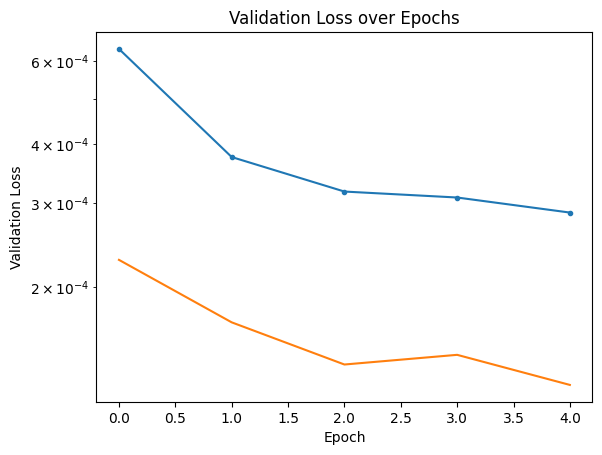

In [ ]:
# Trích xuất giá trị loss trên tập huấn luyện và kiểm tra
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Lấy số lượng epoch
epochs = range(1, len(train_loss) + 1)

# Vẽ biểu đồ
plt.plot(train_loss, marker='.', linestyle='-')
plt.plot(val_loss, marker='', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.yscale('log')  # Scale y-axis to logarithmic scale
plt.show()

# Dự đoán trên tập kiểm tra và tính toán các chỉ số

In [ ]:
# Dự đoán trên tập validation
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
rmse_test = sqrt(mse_test)
rmae_test = sqrt(mae_test)

# Print evaluation results
print("Mean Squared Error (MSE) on test set:", mse_test)
print("Mean Absolute Error (MAE) on test set:", mae_test)
print("R-squared (R2) on test set:", r2_test)
print("Root Mean Squared Error (RMSE) on test set:", rmse_test)
print("Root Mean Absolute Error (RMAE) on test set:", rmae_test)

141/141 [==============================] - 1s 2ms/step
Mean Squared Error (MSE) on test set: 0.00016453821775273331
Mean Absolute Error (MAE) on test set: 0.00944688504057371
R-squared (R2) on test set: 0.8010538907603552
Root Mean Squared Error (RMSE) on test set: 0.012827245134974748
Root Mean Absolute Error (RMAE) on test set: 0.09719508753313466


# Hiển thị biểu đồ kết quả

In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X = df[['Tổng lưu lượng xả (m³/s)[Thực tế]', 'Lưu lượng đến hồ (m³/s)', 'Sum_Mua']]
y = df[['Lưu lượng đến hồ (m³/s)']]
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Tạo nhãn cho dữ liệu
X_data, y_data = create_dataset(X, y, window_size)

# Chia dữ liệu thành tập huấn luyện, kiểm tra và test
train_length = int(len(X) * 0.7)
val_length = int((len(X) - train_length) / 2)

X_train, y_train = X_data[:train_length], y_data[:train_length]
X_test, y_test = X_data[-val_length:], y_data[-val_length:]

# Reshape dữ liệu đầu vào
X_train = X_train.reshape(X_train.shape[0], window_size, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], window_size, X_test.shape[2])

In [ ]:
# Khôi phục dữ liệu sau chuẩn hóa
y_pred_predict = scaler.inverse_transform(y_pred)
y_pred_predict = pd.DataFrame(y_pred_predict)

y_test = scaler.inverse_transform(y_test)
y_test = pd.DataFrame(y_test)

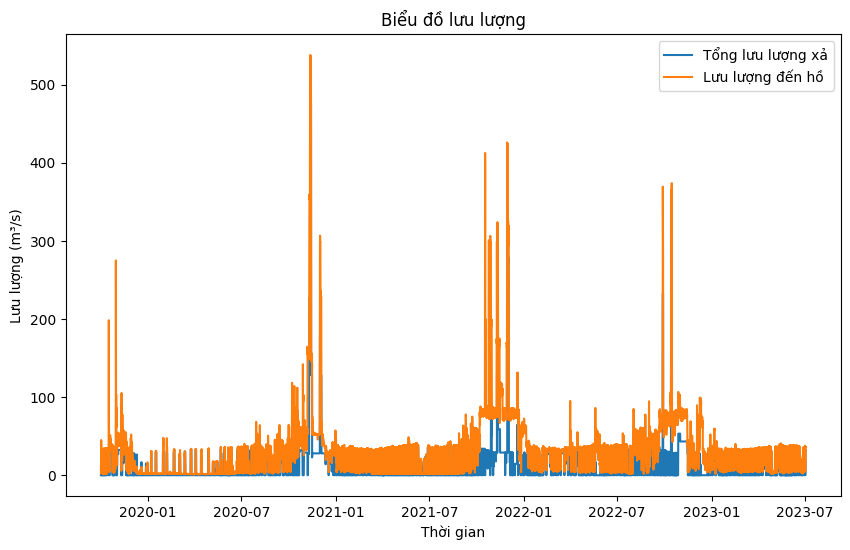

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ dữ liệu gốc
plt.figure(figsize=(10, 6))

plt.plot(df['thoi_gian_KaNak'], df['Tổng lưu lượng xả (m³/s)[Thực tế]'], label='Tổng lưu lượng xả')
plt.plot(df['thoi_gian_KaNak'], df['Lưu lượng đến hồ (m³/s)'], label='Lưu lượng đến hồ')
plt.plot(df['thoi_gian_KaNak'], df['Sum_Mua'], label='Tổng lượng mưa')

plt.xlabel('Thời gian')
plt.ylabel('Lưu lượng (m³/s)')
plt.title('Biểu đồ lưu lượng')
plt.legend()

plt.show()

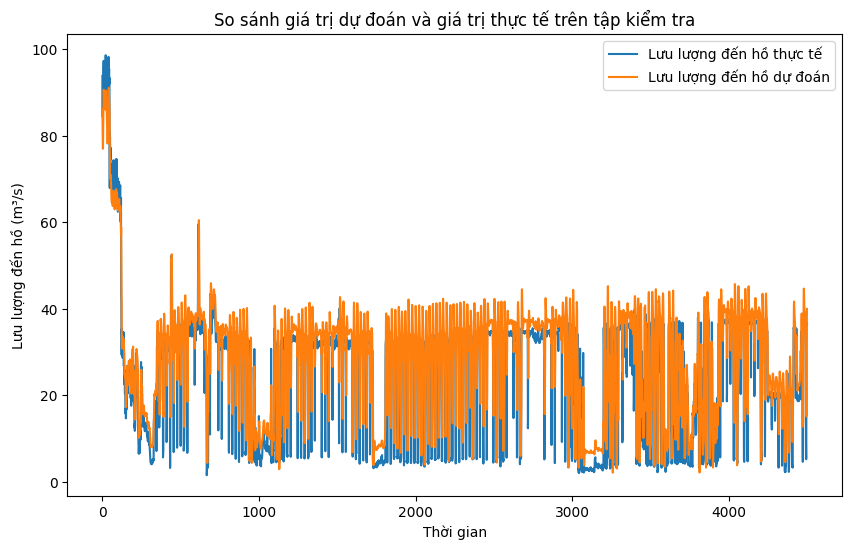

In [ ]:
# Biểu đồ giá trị dự đoán và thực tế trên tập test
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Lưu lượng đến hồ thực tế')
plt.plot(y_pred_predict, label='Lưu lượng đến hồ dự đoán')
plt.xlabel('Thời gian')
plt.ylabel('Lưu lượng đến hồ (m³/s)')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập kiểm tra')
plt.legend()
plt.show()

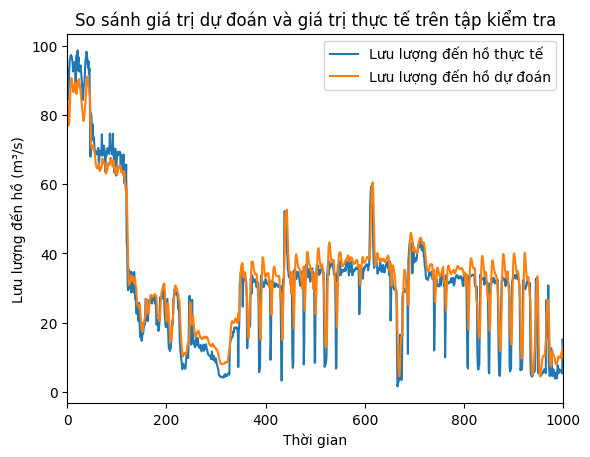

In [ ]:
# Biểu đồ giá trị dự đoán và giá trị thực tế ở điểm bất thường trên tập test
plt.plot(y_test, label='Lưu lượng đến hồ thực tế')
plt.plot(y_pred_predict, label='Lưu lượng đến hồ dự đoán')
plt.xlabel('Thời gian')
plt.ylabel('Lưu lượng đến hồ (m³/s)')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập kiểm tra')
plt.legend()

# Chỉ hiển thị một đoạn nhỏ của biểu đồ
start_index = 0
end_index = 1000
plt.xlim(start_index, end_index)

plt.show()

85/85 [==============================] - 0s 783us/step


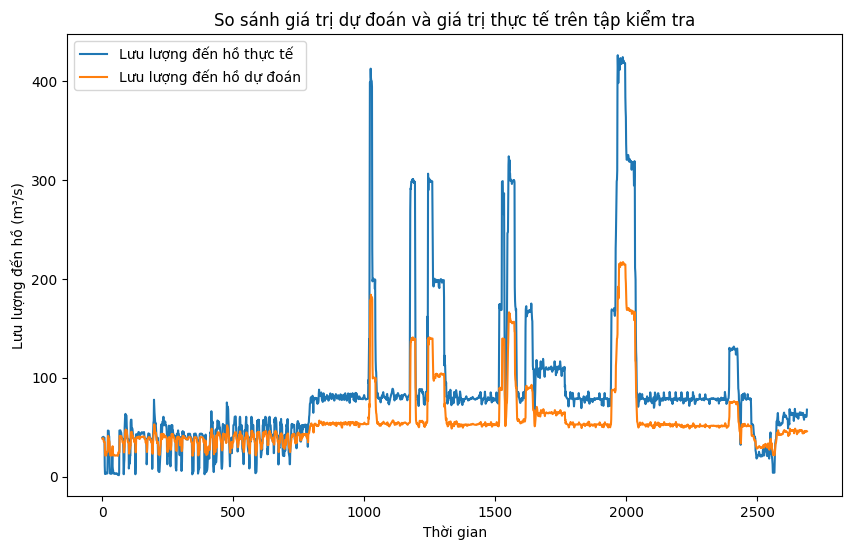

In [ ]:
X_data_slipt = X_train[15290:17980]
y_data_slipt = y_train[15290:17980]

# Dự đoán trên đoạn dữ liệu chỉ định
y_data_slipt_predict = model.predict(X_data_slipt)

# Khôi phục dữ liệu sau chuẩn hóa
y_data_slipt_predict = scaler.inverse_transform(y_data_slipt_predict)
y_data_slipt_predict = pd.DataFrame(y_data_slipt_predict)

y_data_slipt = scaler.inverse_transform(y_data_slipt)
y_data_slipt = pd.DataFrame(y_data_slipt)


# Biểu đồ giá trị dự đoán và giá trị thực tế trên đoạn dữ liệu gốc bất kỳ
plt.figure(figsize=(10, 6))
plt.plot(y_data_slipt, label='Lưu lượng đến hồ thực tế')
plt.plot(y_data_slipt_predict, label='Lưu lượng đến hồ dự đoán')
plt.xlabel('Thời gian')
plt.ylabel('Lưu lượng đến hồ (m³/s)')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập kiểm tra')
plt.legend()
plt.show()